Dataset loaded successfully!
Shape: (307511, 57)

TARGET distribution:
TARGET
0    0.919271
1    0.080729
Name: proportion, dtype: float64

Train TARGET distribution:
 TARGET
0    0.919271
1    0.080729
Name: proportion, dtype: float64

Test TARGET distribution:
 TARGET
0    0.919272
1    0.080728
Name: proportion, dtype: float64

Features scaled successfully!


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 56)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │         7,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bottleneck (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 56)             │         7,224 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 35,288 (137.84 KB)

 Trainable params: 35,288 (137.84 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
884/884 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.1019 - val_loss: 0.0937
Epoch 2/30
884/884 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0482 - val_loss: 0.0098
Epoch 3/30
884/884 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0659 - val_loss: 0.0260
Epoch 4/30
884/884 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0332 - val_loss: 0.0085
Epoch 5/30
884/884 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0382 - val_loss: 0.0072
Epoch 6/30
884/884 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0159 - val_loss: 0.0182
Epoch 7/30
884/884 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0317 - val_loss: 0.0057
Epoch 8/30
884/884 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0149 - val_loss: 0.0031
Epoch 9/30
884/884 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0152 - val_loss: 0.0135
Epoch 10/30
884/884 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0141 - val_loss: 0.0020
Epoch 11/30
884/884 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0105 - val_loss: 0.0015
Epoch 12/30
884/884 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step

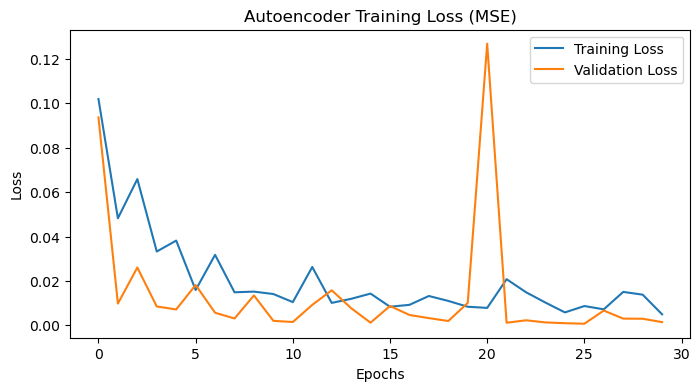

7688/7688 ━━━━━━━━━━━━━━━━━━━━ 4s 567us/step
1922/1922 ━━━━━━━━━━━━━━━━━━━━ 1s 545us/step

Encoded features created successfully!
Train encoded shape: (246008, 33)
Test encoded shape: (61503, 33)

 Default Rate by Cluster:
   Cluster  Average_Default_Rate
1        1              0.066949
2        2              0.084683
0        0              0.088542

 Cluster → Risk Level mapping:
{1: 'Low Risk', 2: 'Medium Risk', 0: 'High Risk'}

 Risk Level Distribution:
Risk_Level
High Risk      142848
Low Risk        85931
Medium Risk     17229
Name: count, dtype: int64


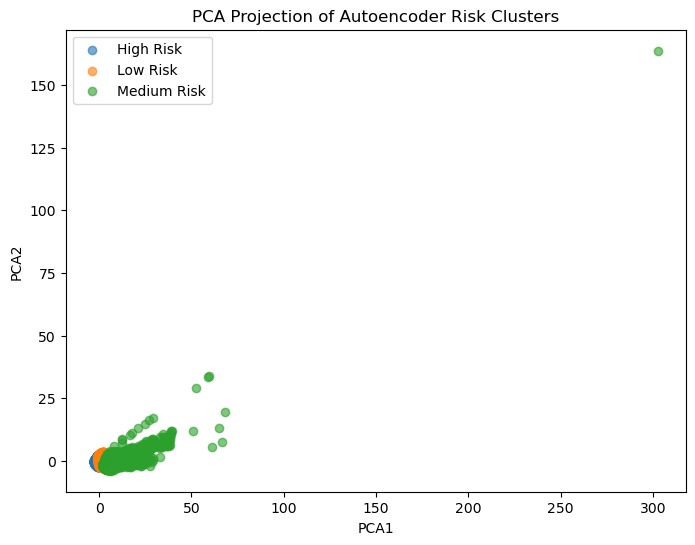


Saved successfully:
→ risk_profiled_autoencoder_train.csv
→ autoencoder_test_features.csv
1922/1922 ━━━━━━━━━━━━━━━━━━━━ 1s 686us/step
7068/7068 ━━━━━━━━━━━━━━━━━━━━ 4s 630us/step

--- Autoencoder Reconstruction Metrics (on test set) ---
Reconstruction MSE (test, aggregated): 0.001511
Reconstruction MAE (test, aggregated): 0.014143


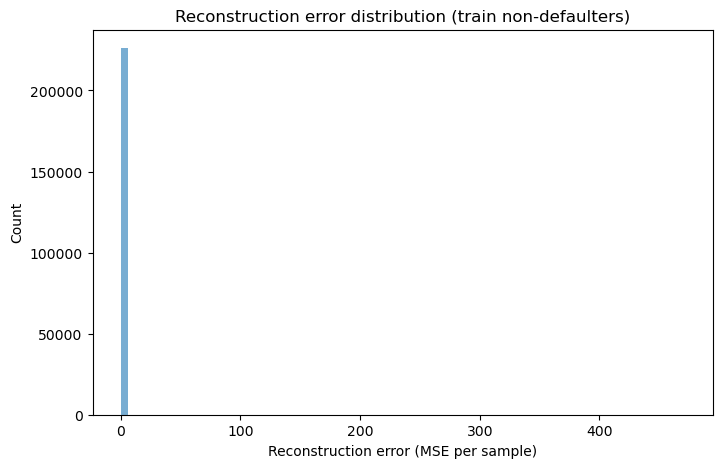

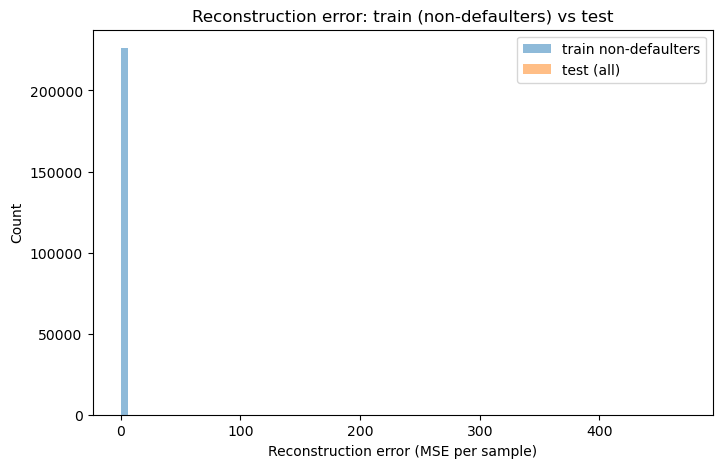


ROC-AUC (autoencoder reconstruction error): 0.5005
Optimal threshold (Youden): 0.001633
95th percentile threshold (train errors): 0.002477

--- Autoencoder Classification-style Metrics (using Youden threshold) ---
Confusion matrix:
 [[51945  4593]
 [ 4467   498]]
Precision: 0.0978, Recall: 0.1003, F1: 0.0990


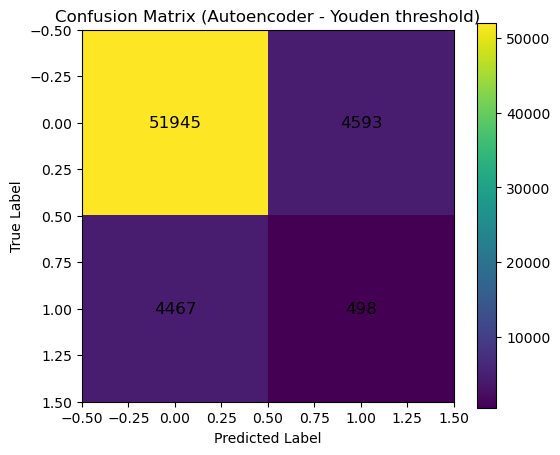

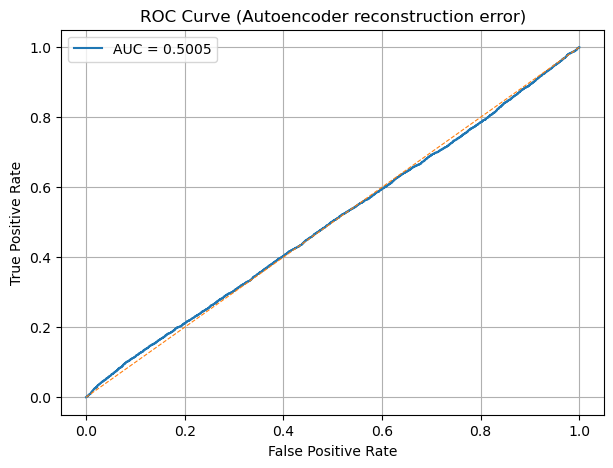

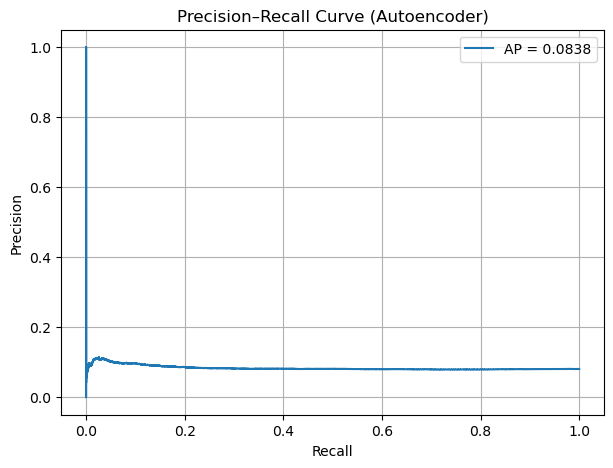


Training supervised classifiers for comparison...

--- Supervised models metrics (on same test set) ---
Logistic Regression: AUC=0.7234, Precision=0.6774, Recall=0.0042, F1=0.0084
Random Forest:        AUC=0.7108, Precision=0.5556, Recall=0.0010, F1=0.0020

All summary results saved to evaluation_results_summary.csv

--- Final summary ---
                         model   roc_auc  precision    recall        f1
0  Autoencoder (AE error->AUC)  0.500524        NaN       NaN       NaN
1    Autoencoder (thresholded)  0.500524   0.097820  0.100302  0.099045
2           LogisticRegression  0.723407   0.677419  0.004230  0.008407
3                 RandomForest  0.710838   0.555556  0.001007  0.002010
Saved test errors to autoencoder_test_errors_with_labels.csv


In [3]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier


DATA_PATH = '../application_train_FinalEDA.csv'
RISK_PROFILE_TRAIN_OUT = "risk_profiled_autoencoder_train.csv"
AE_TEST_FEATURES_OUT = "autoencoder_test_features.csv"
SUMMARY_OUT = "evaluation_results_summary.csv"
RANDOM_STATE = 42


df1 = pd.read_csv(DATA_PATH)
print("Dataset loaded successfully!")
print("Shape:", df1.shape)
print("\nTARGET distribution:")
print(df1['TARGET'].value_counts(normalize=True))


X = df1.drop(columns=['TARGET'])
y = df1['TARGET']

# TRAIN-TEST SPLIT (STRATIFIED)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=RANDOM_STATE
)

print("\nTrain TARGET distribution:\n", y_train.value_counts(normalize=True))
print("\nTest TARGET distribution:\n", y_test.value_counts(normalize=True))

# FEATURE SCALING
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nFeatures scaled successfully!")

# DEFINING AND TRAINING AUTOENCODER
input_dim = X_train_scaled.shape[1]
encoding_dim = 32

# Encoder-Decoder architecture
input_layer = Input(shape=(input_dim,))
encoded = Dense(128, activation='relu')(input_layer)
encoded = Dense(64, activation='relu')(encoded)
bottleneck = Dense(encoding_dim, activation='relu', name="bottleneck")(encoded)
decoded = Dense(64, activation='relu')(bottleneck)
decoded = Dense(128, activation='relu')(decoded)
output_layer = Dense(input_dim, activation='linear')(decoded)

autoencoder = Model(inputs=input_layer, outputs=output_layer)
encoder = Model(inputs=input_layer, outputs=bottleneck)
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

autoencoder.summary()

# Training autoencoder on NON-DEFAULTERS only (anomaly-detection style)
X_train_ae = X_train_scaled[y_train.values == 0]
if X_train_ae.shape[0] < 10:
    print("Warning: very few non-defaulters in training set; autoencoder training may be unstable.")


if (y_test.values == 0).sum() > 0:
    X_val_ae = X_test_scaled[y_test.values == 0]
else:
    X_val_ae = X_test_scaled  # fallback

history = autoencoder.fit(
    X_train_ae, X_train_ae,
    epochs=30,
    batch_size=256,
    validation_data=(X_val_ae, X_val_ae),
    verbose=1
)

# Plot loss curves
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Autoencoder Training Loss (MSE)")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# EXTRACTING ENCODED (LATENT) FEATURES
X_train_encoded = encoder.predict(X_train_scaled)
X_test_encoded = encoder.predict(X_test_scaled)

encoded_train_df = pd.DataFrame(X_train_encoded, columns=[
                                f"encoded_{i}" for i in range(encoding_dim)])
encoded_test_df = pd.DataFrame(X_test_encoded, columns=[
                               f"encoded_{i}" for i in range(encoding_dim)])

encoded_train_df['TARGET'] = y_train.reset_index(drop=True)
encoded_test_df['TARGET'] = y_test.reset_index(drop=True)

print("\nEncoded features created successfully!")
print("Train encoded shape:", encoded_train_df.shape)
print("Test encoded shape:", encoded_test_df.shape)

# K-MEANS CLUSTERING (RISK PROFILING)
X_encoded = encoded_train_df.drop(columns=['TARGET'])
y_encoded = encoded_train_df['TARGET']

kmeans = KMeans(n_clusters=3, random_state=RANDOM_STATE)
encoded_train_df['Cluster'] = kmeans.fit_predict(X_encoded)

cluster_summary = (
    encoded_train_df.groupby('Cluster')['TARGET']
    .mean()
    .reset_index()
    .sort_values(by='TARGET')
)
cluster_summary.columns = ['Cluster', 'Average_Default_Rate']

print("\n Default Rate by Cluster:")
print(cluster_summary)

# LABEL CLUSTERS AS RISK LEVELS
risk_map = cluster_summary.sort_values(
    'Average_Default_Rate').reset_index(drop=True)
risk_map['Risk_Level'] = ['Low Risk', 'Medium Risk', 'High Risk']
risk_label_dict = dict(zip(risk_map['Cluster'], risk_map['Risk_Level']))

encoded_train_df['Risk_Level'] = encoded_train_df['Cluster'].map(
    risk_label_dict)

print("\n Cluster → Risk Level mapping:")
print(risk_label_dict)
print("\n Risk Level Distribution:")
print(encoded_train_df['Risk_Level'].value_counts())

# VISUALIZE CLUSTERS USING PCA
pca = PCA(n_components=2, random_state=RANDOM_STATE)
pca_result = pca.fit_transform(X_encoded)

encoded_train_df['PCA1'] = pca_result[:, 0]
encoded_train_df['PCA2'] = pca_result[:, 1]

plt.figure(figsize=(8, 6))
for level in encoded_train_df['Risk_Level'].unique():
    subset = encoded_train_df[encoded_train_df['Risk_Level'] == level]
    plt.scatter(subset['PCA1'], subset['PCA2'], label=level, alpha=0.6)
plt.title("PCA Projection of Autoencoder Risk Clusters")
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.legend()
plt.show()

# SAVE THE RISK-PROFILED DATASET
encoded_train_df.to_csv(RISK_PROFILE_TRAIN_OUT, index=False)
encoded_test_df.to_csv(AE_TEST_FEATURES_OUT, index=False)

print("\nSaved successfully:")
print("→", RISK_PROFILE_TRAIN_OUT)
print("→", AE_TEST_FEATURES_OUT)

# EVALUATION: Reconstruction metrics, distribution, ROC-AUC, thresholding, confusion matrix

# Reconstruct test set using autoencoder
X_test_recon = autoencoder.predict(X_test_scaled)
# Per-sample reconstruction error (MSE per sample)
test_errors = np.mean(np.square(X_test_scaled - X_test_recon), axis=1)

# Reconstruction on training non-defaulters used for AE training (for thresholding & distribution)
X_train_ae_recon = autoencoder.predict(X_train_ae)
train_errors = np.mean(np.square(X_train_ae - X_train_ae_recon), axis=1)

# Aggregated reconstruction metrics (on full test set)
recon_mse = mean_squared_error(X_test_scaled, X_test_recon)
recon_mae = mean_absolute_error(X_test_scaled, X_test_recon)

print("\n--- Autoencoder Reconstruction Metrics (on test set) ---")
print(f"Reconstruction MSE (test, aggregated): {recon_mse:.6f}")
print(f"Reconstruction MAE (test, aggregated): {recon_mae:.6f}")

# Plot reconstruction error distribution (train non-defaulters)
plt.figure(figsize=(8, 5))
plt.hist(train_errors, bins=80, alpha=0.6)
plt.title('Reconstruction error distribution (train non-defaulters)')
plt.xlabel('Reconstruction error (MSE per sample)')
plt.ylabel('Count')
plt.show()

# reconstruction error histogram (overlay)
plt.figure(figsize=(8, 5))
plt.hist(train_errors, bins=80, alpha=0.5, label='train non-defaulters')
plt.hist(test_errors, bins=80, alpha=0.5, label='test (all)')
plt.title('Reconstruction error: train (non-defaulters) vs test')
plt.xlabel('Reconstruction error (MSE per sample)')
plt.ylabel('Count')
plt.legend()
plt.show()

# ROC-AUC using reconstruction error as anomaly score
roc_auc = roc_auc_score(y_test, test_errors)
fpr, tpr, thresholds = roc_curve(y_test, test_errors)
print(f"\nROC-AUC (autoencoder reconstruction error): {roc_auc:.4f}")

# Chose threshold via Youden's J statistic
j_scores = tpr - fpr
j_idx = np.argmax(j_scores)
opt_threshold = thresholds[j_idx]
# 95th percentile of training non-defaulters
pct_threshold = np.percentile(train_errors, 95)

print(f"Optimal threshold (Youden): {opt_threshold:.6f}")
print(f"95th percentile threshold (train errors): {pct_threshold:.6f}")

# Binary predictions using chosen threshold (Youden)
y_pred_ae = (test_errors >= opt_threshold).astype(int)

prec_ae = precision_score(y_test, y_pred_ae, zero_division=0)
rec_ae = recall_score(y_test, y_pred_ae, zero_division=0)
f1_ae = f1_score(y_test, y_pred_ae, zero_division=0)
cm_ae = confusion_matrix(y_test, y_pred_ae)

print("\n--- Autoencoder Classification-style Metrics (using Youden threshold) ---")
print("Confusion matrix:\n", cm_ae)
print(f"Precision: {prec_ae:.4f}, Recall: {rec_ae:.4f}, F1: {f1_ae:.4f}")

plt.figure(figsize=(6, 5))
plt.imshow(cm_ae, interpolation='nearest')
plt.title("Confusion Matrix (Autoencoder - Youden threshold)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
for i in range(cm_ae.shape[0]):
    for j in range(cm_ae.shape[1]):
        plt.text(j, i, cm_ae[i, j], ha="center", va="center", fontsize=12)
plt.colorbar()
plt.show()


plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle='--', linewidth=0.8)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Autoencoder reconstruction error)")
plt.legend()
plt.grid(True)
plt.show()


precision_vals, recall_vals, pr_thresholds = precision_recall_curve(
    y_test, test_errors)
ap_score = average_precision_score(y_test, test_errors)

precision_vals, recall_vals, pr_thresholds = precision_recall_curve(
    y_test, test_errors)
ap_score = average_precision_score(y_test, test_errors)

plt.figure(figsize=(7, 5))
plt.plot(recall_vals, precision_vals, label=f"AP = {ap_score:.4f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve (Autoencoder)")
plt.legend()
plt.grid(True)
plt.show()

# COMPARISON WITH SUPERVISED MODELS
print("\nTraining supervised classifiers for comparison...")

lr = LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)
rf = RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE)

lr.fit(X_train_scaled, y_train)
rf.fit(X_train_scaled, y_train)

# Probabilities and preds on test
y_proba_lr = lr.predict_proba(X_test_scaled)[:, 1]
y_pred_lr = lr.predict(X_test_scaled)

y_proba_rf = rf.predict_proba(X_test_scaled)[:, 1]
y_pred_rf = rf.predict(X_test_scaled)

# Metrics
auc_lr = roc_auc_score(y_test, y_proba_lr)
prec_lr = precision_score(y_test, y_pred_lr, zero_division=0)
rec_lr = recall_score(y_test, y_pred_lr, zero_division=0)
f1_lr = f1_score(y_test, y_pred_lr, zero_division=0)

auc_rf = roc_auc_score(y_test, y_proba_rf)
prec_rf = precision_score(y_test, y_pred_rf, zero_division=0)
rec_rf = recall_score(y_test, y_pred_rf, zero_division=0)
f1_rf = f1_score(y_test, y_pred_rf, zero_division=0)

print('\n--- Supervised models metrics (on same test set) ---')
print('Logistic Regression: AUC={:.4f}, Precision={:.4f}, Recall={:.4f}, F1={:.4f}'.format(
    auc_lr, prec_lr, rec_lr, f1_lr))
print('Random Forest:        AUC={:.4f}, Precision={:.4f}, Recall={:.4f}, F1={:.4f}'.format(
    auc_rf, prec_rf, rec_rf, f1_rf))

# Save summary table
results = pd.DataFrame({
    'model': ['Autoencoder (AE error->AUC)', 'Autoencoder (thresholded)', 'LogisticRegression', 'RandomForest'],
    'roc_auc': [roc_auc, roc_auc, auc_lr, auc_rf],
    'precision': [np.nan, prec_ae, prec_lr, prec_rf],
    'recall': [np.nan, rec_ae, rec_lr, rec_rf],
    'f1': [np.nan, f1_ae, f1_lr, f1_rf]
})
results.to_csv(SUMMARY_OUT, index=False)
print(f"\nAll summary results saved to {SUMMARY_OUT}")


print("\n--- Final summary ---")
print(results)


test_results_df = pd.DataFrame({
    'reconstruction_error': test_errors,
    'y_true': y_test.reset_index(drop=True),
    'y_pred_ae_youden': y_pred_ae
})
test_results_df.to_csv("autoencoder_test_errors_with_labels.csv", index=False)
print("Saved test errors to autoencoder_test_errors_with_labels.csv")

Saved model_comparison_summary.csv
                model   roc_auc  average_precision  precision    recall  \
0         Autoencoder  0.500524           0.083772   0.097820  0.100302   
1  LogisticRegression  0.723407           0.208437   0.677419  0.004230   
2        RandomForest  0.710838           0.200911   0.555556  0.001007   

         f1  
0  0.099045  
1  0.008407  
2  0.002010  


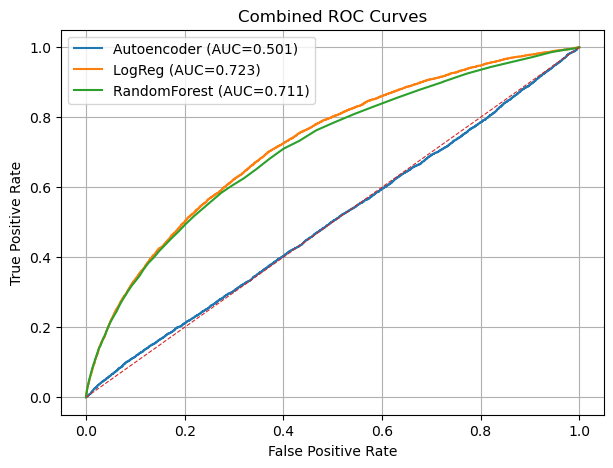

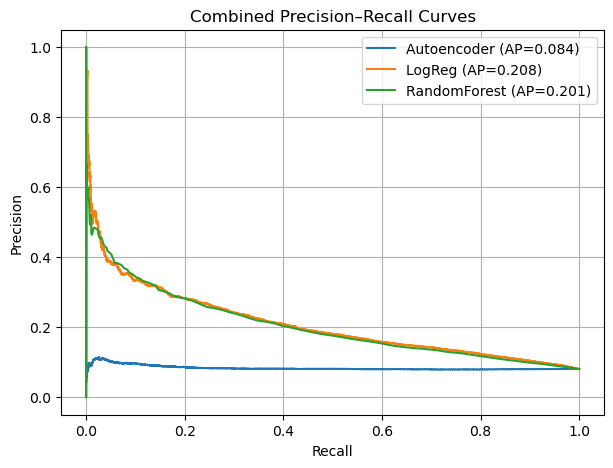

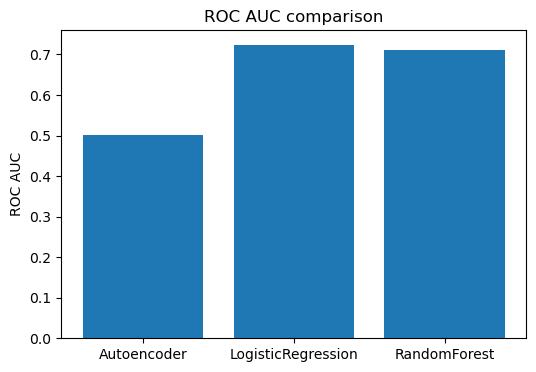

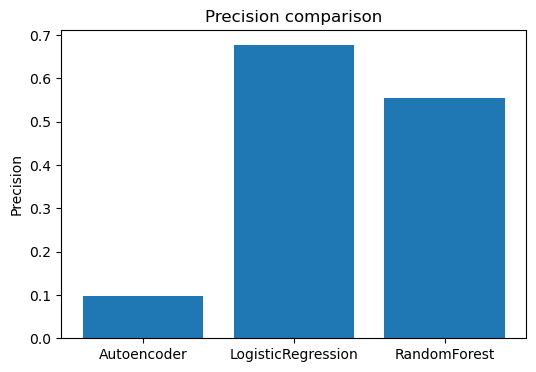

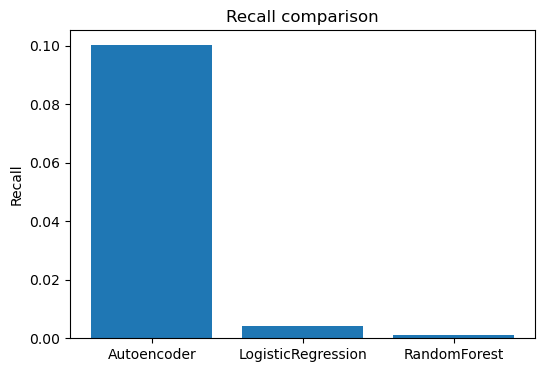

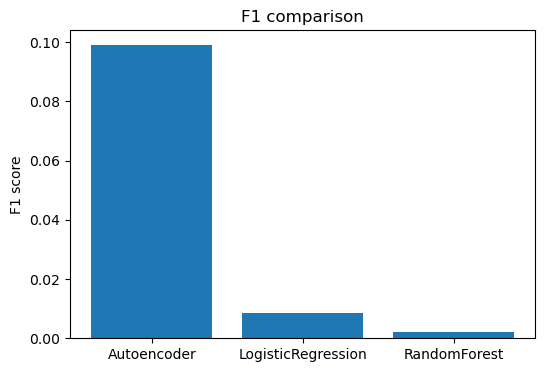

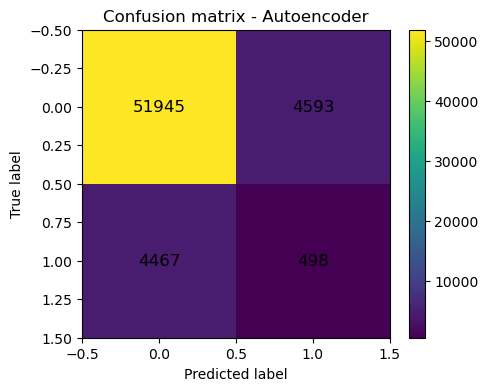

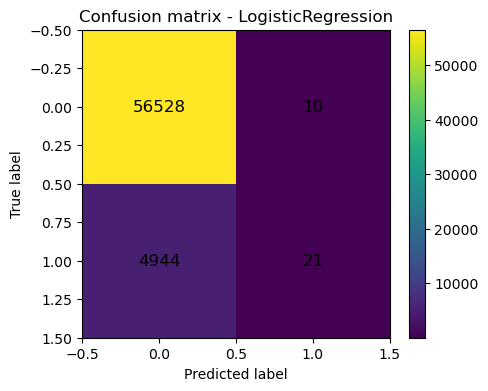

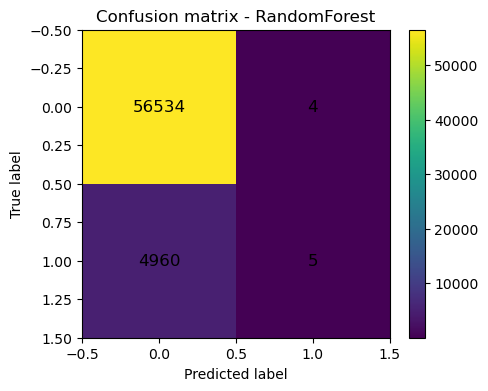

In [ ]:
import pandas as pd
from sklearn.metrics import roc_auc_score
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve, average_precision_score, confusion_matrix, precision_score, recall_score, f1_score


# AE anomaly score (higher -> more likely default)
ae_scores = test_errors
lr_scores = y_proba_lr
rf_scores = y_proba_rf

# ROC curves
fpr_ae, tpr_ae, _ = roc_curve(y_test, ae_scores)
fpr_lr, tpr_lr, _ = roc_curve(y_test, lr_scores)
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_scores)


auc_ae = roc_auc_score(y_test, ae_scores)
auc_lr = roc_auc_score(y_test, lr_scores)
auc_rf = roc_auc_score(y_test, rf_scores)

# Precision-Recall curves and AP
prec_ae, rec_ae, _ = precision_recall_curve(y_test, ae_scores)
ap_ae = average_precision_score(y_test, ae_scores)

prec_lr, rec_lr, _ = precision_recall_curve(y_test, lr_scores)
ap_lr = average_precision_score(y_test, lr_scores)

prec_rf, rec_rf, _ = precision_recall_curve(y_test, rf_scores)
ap_rf = average_precision_score(y_test, rf_scores)


metrics = {}
for name, y_pred, scores in [
    ("Autoencoder", y_pred_ae, ae_scores),
    ("LogisticRegression", y_pred_lr, lr_scores),
    ("RandomForest", y_pred_rf, rf_scores),
]:
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    cm = confusion_matrix(y_test, y_pred)
    roc_auc_val = roc_auc_score(y_test, scores)
    ap_val = average_precision_score(y_test, scores)
    metrics[name] = {
        'precision': precision, 'recall': recall, 'f1': f1, 'cm': cm,
        'auc': roc_auc_val, 'ap': ap_val
    }

# Build summary dataframe
summary = pd.DataFrame([
    {
        'model': m,
        'roc_auc': metrics[m]['auc'],
        'average_precision': metrics[m]['ap'],
        'precision': metrics[m]['precision'],
        'recall': metrics[m]['recall'],
        'f1': metrics[m]['f1']
    }
    for m in metrics
])
summary = summary[['model', 'roc_auc',
                   'average_precision', 'precision', 'recall', 'f1']]
summary.to_csv("model_comparison_summary.csv", index=False)
print("Saved model_comparison_summary.csv")
print(summary)


try:
    import ace_tools as tools
    tools.display_dataframe_to_user("Model comparison summary", summary)
except Exception:
    pass


# 1) Combined ROC curve

plt.figure(figsize=(7, 5))
plt.plot(fpr_ae, tpr_ae, label=f"Autoencoder (AUC={auc_ae:.3f})")
plt.plot(fpr_lr, tpr_lr, label=f"LogReg (AUC={auc_lr:.3f})")
plt.plot(fpr_rf, tpr_rf, label=f"RandomForest (AUC={auc_rf:.3f})")
plt.plot([0, 1], [0, 1], linestyle='--', linewidth=0.8)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Combined ROC Curves")
plt.legend()
plt.grid(True)
plt.show()


# 2) Combined Precision-Recall curves

plt.figure(figsize=(7, 5))
plt.plot(rec_ae, prec_ae, label=f"Autoencoder (AP={ap_ae:.3f})")
plt.plot(rec_lr, prec_lr, label=f"LogReg (AP={ap_lr:.3f})")
plt.plot(rec_rf, prec_rf, label=f"RandomForest (AP={ap_rf:.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Combined Precision–Recall Curves")
plt.legend()
plt.grid(True)
plt.show()


# 3) AUC comparison (bar)

plt.figure(figsize=(6, 4))
models = summary['model'].tolist()
aucs = summary['roc_auc'].values
x = np.arange(len(models))
plt.bar(x, aucs)
plt.xticks(x, models)
plt.ylabel("ROC AUC")
plt.title("ROC AUC comparison")
plt.show()


# 4) Precision / Recall / F1 (one plot each)

# Precision
plt.figure(figsize=(6, 4))
plt.bar(x, summary['precision'].values)
plt.xticks(x, models)
plt.ylabel("Precision")
plt.title("Precision comparison")
plt.show()

# Recall
plt.figure(figsize=(6, 4))
plt.bar(x, summary['recall'].values)
plt.xticks(x, models)
plt.ylabel("Recall")
plt.title("Recall comparison")
plt.show()

# F1
plt.figure(figsize=(6, 4))
plt.bar(x, summary['f1'].values)
plt.xticks(x, models)
plt.ylabel("F1 score")
plt.title("F1 comparison")
plt.show()


# 5) Confusion matrices (one figure per model)

for m in models:
    cm = metrics[m]['cm']
    plt.figure(figsize=(5, 4))
    plt.imshow(cm, interpolation='nearest')
    plt.title(f"Confusion matrix - {m}")
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, int(cm[i, j]), ha='center',
                     va='center', fontsize=12)
    plt.colorbar()
    plt.show()